In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import json
import csv
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/med-train/train.csv
/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [4]:
pip install transformers==2.6.0

     |████████████████████████████████| 540 kB 3.4 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 2.8.0
    Uninstalling transformers-2.8.0:
      Successfully uninstalled transformers-2.8.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
#/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/
data = pd.read_csv("../input/med-train/train.csv", encoding="latin1").fillna(method="ffill")
data.head(50)

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,Obesity,O
1,2,1,1,in,O
2,3,1,1,Low-,O
3,4,1,1,and,O
4,5,1,1,Middle-Income,O
5,6,1,1,Countries,O
6,7,1,1,:,O
7,8,1,1,Burden,O
8,9,1,1,",",O
9,10,1,1,Drivers,O


In [6]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
       # agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
       #                                                    s["POS"].values.tolist(),
        #                                                   s["Tag"].values.tolist())]
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("Sent_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)

In [8]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

#an example of sentence

['Obesity',
 'in',
 'Low-',
 'and',
 'Middle-Income',
 'Countries',
 ':',
 'Burden',
 ',',
 'Drivers',
 ',',
 'and',
 'Emerging',
 'Challenges',
 '.']

In [9]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])
#BIO schema is followed in the datSET

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [10]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
#Padding is addded end of each sentence,

Preprocess the sentence nd labels. prepare to use with pytorch and bert

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

Using TensorFlow backend.


'1.4.0'

In [12]:
MAX_LEN = 75
bs = 32
#batch size = bs
# sentence length fixed to 75 i.e. 75 tokens
# but bert supports up to 512 tokens 

Here we fix some configurations. We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [14]:
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 
#cased better for for ner

In [16]:
# tokenize wala step ## wala step jaise gunships ##shipa
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [17]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [18]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [19]:
#cut and pad to the desied length 75 bcz ab no of token increase ho gya
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [20]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [21]:
#attenation mask to ignore PAD token
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [22]:
#10per train and validATE
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [23]:
# convert to torch tenors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [24]:
#training time shuffling of the data and testing time we pass them sequentially
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


Fine tune

In [25]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'2.6.0'

In [26]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [27]:
model.cuda();

now fine tuning uske liye optimizer use krna hai and we are using AdamW.

In [28]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [29]:
#schduler to reduce learning rate linearly throughout the epochs
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Fit bert for ner

In [30]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [31]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.056434272159216405
Validation loss: 0.04192465810762425
Validation Accuracy: 0.43279450947603115


Epoch:  33%|███▎      | 1/3 [26:07<52:15, 1567.77s/it]

Validation F1-Score: 0.7660285322909357

Average train loss: 0.02884409814271522
Validation loss: 0.0343961103444173
Validation Accuracy: 0.43399774247491596


Epoch:  67%|██████▋   | 2/3 [52:17<26:08, 1568.25s/it]

Validation F1-Score: 0.8128782053425162

Average train loss: 0.015687444326605217
Validation loss: 0.03473551546063926
Validation Accuracy: 0.43457335562987737


Epoch: 100%|██████████| 3/3 [1:18:33<00:00, 1571.12s/it]

Validation F1-Score: 0.8314629667414813



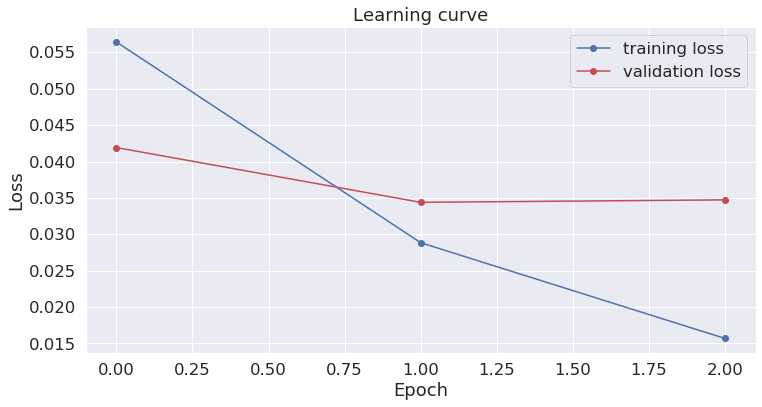

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [33]:
test_sentence = """
CCCVA, MANOVA, my black hen. Comments on repeated measures. Nikolsky sign page from notable contributors to the knowledge of dermatology.
[Obesity as a concomitant cause in the complex etiology of arteriosclerosis ]. Tropical mixtures of star tree metrics.
We study three metrics that can be realized as a mixture of two-star tree metrics.
We prove that the only trees admitting such a decomposition are the ones coming from a tree with at most one internal edge, and whose weight satisfies certain linear inequalities.
We also characterize the fibers of the corresponding mixture map. In addition, we discuss the general framework of tropical secant varieties and we interpret our results within this setting.
Finally, we show that the set of tree metric ranks of metrics on $ n $ taxa is unbounded. 
Comment: 19 pages, 5 figures. Major revision of the exposition following suggestions by the referee.
To appear in Annals of Combinatoric Pasteurellosis in japanese quail (Coturnix coturnix japonica) caused by Pasteurella multocida multocida A:4. 
NUTRITIONAL WELL-BEING IN THE U.S.A.Counseling professional nurses. Evaluation of transdermal penetration enhancers using a novel skin alternative . 
A novel alternative to animal skin models was developed in order to aid in the screening of transdermal penetration enhancer . 
The skin alternative consists of a dermal layer containing human fibroblasts dispersed in a collagen matrix and an epidermal layer of differentiated and stratified human keratinocytes.

"""


In [34]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [35]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [36]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [37]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	CCCVA
O	,
O	MANOVA
O	,
O	my
O	black
O	hen
O	.
O	Comments
O	on
O	repeated
O	measures
O	.
O	Nikolsky
O	sign
O	page
O	from
O	notable
O	contributors
O	to
O	the
O	knowledge
O	of
O	dermatology
O	.
O	[
O	Obesity
O	as
O	a
O	concomitant
O	cause
O	in
O	the
O	complex
O	etiology
O	of
O	arteriosclerosis
O	]
O	.
O	Tropical
O	mixtures
O	of
O	star
O	tree
O	metrics
O	.
O	We
O	study
O	three
O	metrics
O	that
O	can
O	be
O	realized
O	as
O	a
O	mixture
O	of
O	two
O	-
O	star
O	tree
O	metrics
O	.
O	We
O	prove
O	that
O	the
O	only
O	trees
O	admitting
O	such
O	a
O	decomposition
O	are
O	the
O	ones
O	coming
O	from
O	a
O	tree
O	with
O	at
O	most
O	one
O	internal
O	edge
O	,
O	and
O	whose
O	weight
O	satisfies
O	certain
O	linear
O	inequalities
O	.
O	We
O	also
O	characterize
O	the
O	fibers
O	of
O	the
O	corresponding
O	mixture
O	map
O	.
O	In
O	addition
O	,
O	we
O	discuss
O	the
O	general
O	framework
O	of
O	tropical
O	secant
O	varieties
O	and
O	we
O	interpret
O	our
O	results
O	within
O	this
O	setting
O	.
O	Finally